In [58]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms

In [59]:
from torch import classes
from torchvision import datasets

First we define the batch size which is a important entity. The batch size is the number of samples we feed our network per iteration.

In [60]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                            download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                           download=True, transform=transform)

validation_data = datasets.MNIST(root='validation', train=True, download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size,
                                          num_workers=num_workers)

Now we visualize one batch of the size of 20, if you did not change the batch size already.
The dimension one image is pixel in x = 28, pixel in y = 28

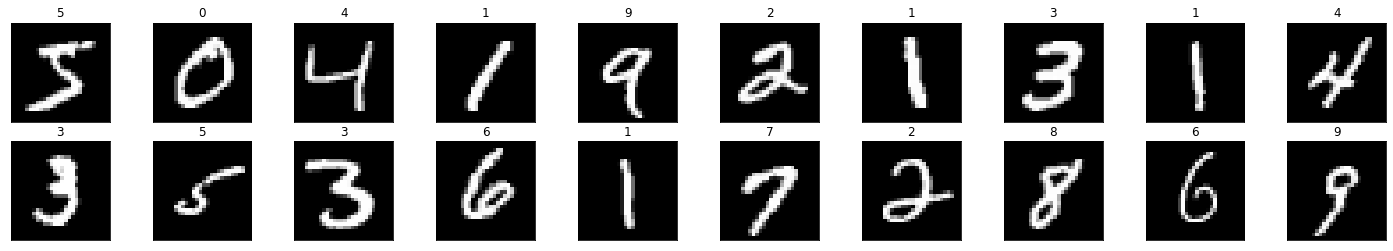

In [61]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

Let's visualize one data point.

img = np.squeeze(images[1])

fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

We now define our two architectures. A neural network is firstly defined through the constructor. Then the forward method will be defined.

# Architecture 1:

* Convolutional layer
* Linear layer

In the beginning we have $28 \times 28 = 784$ weights to one hidden node.
The first convolutional layer with a kernel of 5 and a stride of 0 transforms the dimension of the input $28 \times 28$ to $24 \times 24$.
In general we can say $new\_dimension = \frac{input\_dimension - (kernel\_size - 1) - 1 }{stride} + 1$ or for $stride = 1$
$new\_dimension = int(input\_dimension - 2 \cdot int(\frac{kernel\_size}{2}))$

In [62]:
class Net_1(nn.Module):
    def __init__(self):
        super(Net_1, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, (5, 5)) # 28 -> 24
        self.fc2 = nn.Linear(20 * 24 ** 2, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # convolutional layer with ReLu-activation-function
        x = x.view(-1, 20 * (24 ** 2)) # flatten image input
        x = self.fc2(x) # poss through linear layer
        # for other loss functions you may need
        # x = x / torch.norm(x) # output to probability
        return x

# initialize model
model = Net_1()
model(torch.Tensor(images))

tensor([[ 0.1027, -0.0577, -0.0299, -0.1949,  0.0433,  0.0429,  0.0637, -0.0313,
         -0.0896, -0.1227],
        [ 0.0957, -0.0589, -0.0980, -0.1669, -0.0181, -0.0756, -0.0234, -0.0065,
          0.0750, -0.0851],
        [ 0.0670, -0.0963, -0.0192, -0.0580, -0.1292, -0.0125,  0.0900, -0.0735,
         -0.1226, -0.0104],
        [ 0.0493, -0.0565,  0.0319, -0.1390,  0.0226, -0.0227, -0.0141,  0.0385,
         -0.0570, -0.0984],
        [ 0.0333, -0.1550,  0.0284, -0.1165, -0.0056,  0.0219,  0.0044, -0.0533,
          0.0023, -0.0690],
        [ 0.0401, -0.1864, -0.0286, -0.1253, -0.0562, -0.0210,  0.0778,  0.0703,
         -0.0062, -0.0640],
        [ 0.0443, -0.1604, -0.0048, -0.0778,  0.0404, -0.0677,  0.0092, -0.0395,
         -0.0562, -0.1439],
        [ 0.0422, -0.0665, -0.1253, -0.1935, -0.1374,  0.0603,  0.0686, -0.0944,
         -0.1108, -0.0909],
        [ 0.0337, -0.0912, -0.0107, -0.0651,  0.0148,  0.0030,  0.0504,  0.0074,
         -0.0459, -0.1334],
        [ 0.0545, -

# Architecture 2:

* Convolutional layer
* [Maxpooling](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) layer
* Convolutional
* Maxpool layer
* Convolutional layer
* Maxpool layer
* Linear layer
* Softmax layer
* Batch normalisation

The maxpooling operation devides our input dimension in each "direction" with $\frac{1}{kernel\_size}$.



In [63]:
class Net_2(nn.Module):
    def __init__(self):
        super(Net_2, self).__init__()
        # linear layer (784 -> 1 hidden node)
        self.conv1 = nn.Conv2d(1, 20, (3, 3)) # 28 -> 26
        self.maxpool2 = nn.MaxPool2d((2, 2)) # 26 -> 13
        self.conv3 = nn.Conv2d(20, 80, (3, 3)) # 13 -> 11
        self.batchnorm4 = nn.BatchNorm2d(80) # batch norm
        self.maxpool5 = nn.MaxPool2d((2, 2)) # 11 -> 5
        self.conv6 = nn.Conv2d(80, 320, (3, 3)) # 5 -> 3
        self.fc7 = nn.Linear(320 * (3 ** 2), 10) # linear layer



    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool2(x) # maxpooling operation
        x = F.relu(self.conv3(x))
        x = self.batchnorm4(x)
        x = self.maxpool5(x)
        x = F.relu(self.conv6(x))
        x = x.view(-1, 320 * (3 ** 2)) # flatten image input
        x = self.fc7(x)
        # for other loss functions you may need
        # x = x / torch.norm(x) # output to probability

        return x


# if you want to train this architecture remove the comments below:
# model = Net_2()
# model(torch.Tensor(images))

## Adaptive learning rates:

For some problems it is sensible to adjust the learning rate during training. Here I implemented a function that does so.

In [64]:
def decaying_learning_rate(final_lr, epoch):
    if epoch < 4:
        return final_lr
    print(final_lr / (10 ** (epoch / 10)))
    return final_lr / (10 ** (epoch / 10))

## Early Stopping
Early Stopping is a method to prevent a model from overfitting.
One can either stop, when the training loss get's really small or one validates the network after every epoch and see's when the validation loss becomes vanishing small.

In [65]:
earlyStop = False
def early_stopping(train_loss):
    if train_loss < 1E-5:
        return True
    else: False

In [66]:
final_learningrate = 0.01

criterion = nn.CrossEntropyLoss() # Loss function

optimizer = torch.optim.SGD(model.parameters(), lr = final_learningrate, momentum = 0.9) # play around with momentum

## Train the Network

1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss


In [ ]:
# number of epochs to train the model
n_epochs = 30
plot_data = np.zeros(n_epochs)
# memory = torch.empty(size=(, n_epochs))

# number of epochs to train the model

model.train() # prep model for training

#for epoch in range(n_epochs):
epoch = 0

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0

    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        # if you want to use a different loss function
        # target = F.one_hot(target, 10).float()
        loss = criterion(output, target)

        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)

    # print training statistics

    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    plot_data[epoch] = train_loss
    optimizer = torch.optim.SGD(model.parameters(), lr=final_learningrate, momentum=0.9) # if you want to have adaptive learning rates remove comment below
    # optimizer = torch.optim.SGD(model.parameters(), lr=decaying_learning_rate(final_lr=final_learningrate), momentum=0.9)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        train_loss
        ))
    if early_stopping(train_loss) and earlyStop:
        continue

Epoch: 1 	Training Loss: 0.037226
Epoch: 2 	Training Loss: 0.028896
Epoch: 3 	Training Loss: 0.022678
Epoch: 4 	Training Loss: 0.017712
Epoch: 5 	Training Loss: 0.013577
Epoch: 6 	Training Loss: 0.010331
Epoch: 7 	Training Loss: 0.008149


For our consciousness we make a plot to see if the training loss really decreased over the training epochs.

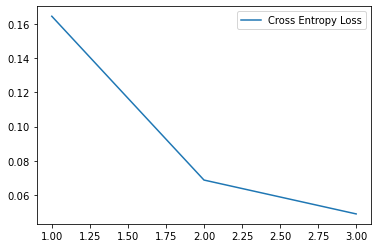

In [68]:
fig, ax = plt.subplots()
ax.plot((np.linspace(1, n_epochs, n_epochs)), plot_data, '-', label='Cross Entropy Loss')
plt.legend()
plt.show()

In [69]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss

    target = F.one_hot(target, 10).float()

    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label

    target = torch.argmax(target, dim=1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.060379

Test Accuracy of     0: 98% (965/980)
Test Accuracy of     1: 99% (1129/1135)
Test Accuracy of     2: 98% (1017/1032)
Test Accuracy of     3: 97% (981/1010)
Test Accuracy of     4: 98% (968/982)
Test Accuracy of     5: 99% (886/892)
Test Accuracy of     6: 95% (911/958)
Test Accuracy of     7: 97% (1001/1028)
Test Accuracy of     8: 98% (958/974)
Test Accuracy of     9: 96% (978/1009)

Test Accuracy (Overall): 97% (9794/10000)


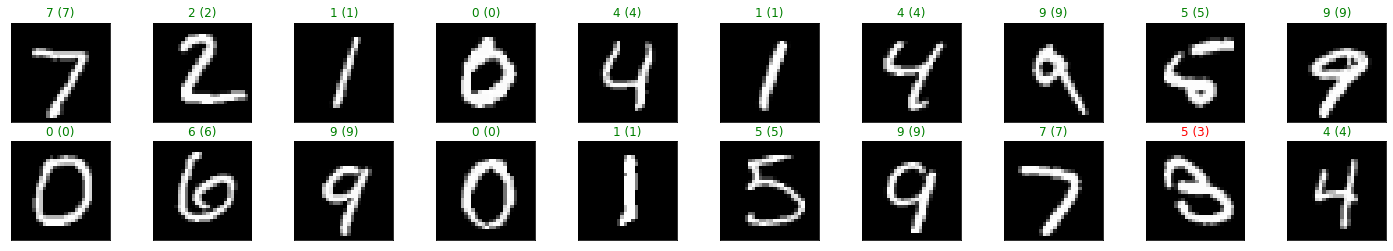

In [70]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 // 2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))